In [1]:
import pandas as pd

In [62]:
import matplotlib.pyplot as plt

In [63]:
import numpy as np

In [89]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [155]:
from sklearn.metrics import roc_curve, auc

Домашнее задание
-----------------------------

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

### Загрузка исходных данных

In [3]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [4]:
news.shape

(27000, 2)

In [5]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


#### Подготовка датасета к обработке

In [6]:
from gensim.corpora.dictionary import Dictionary

In [64]:
import re
from nltk.corpus import stopwords
from razdel import tokenize
import pymorphy2

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ПК\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

Список стоп слов для русского языка.

In [9]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

151

In [11]:
morph = pymorphy2.MorphAnalyzer(  )

In [12]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [15]:
def clean_text(text):
    '''очистка текста  на выходе очищеный текст '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub("n", ' ', text)

    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

In [16]:
cache = {}

In [17]:
def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    #print(tokens)
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
                #print(temp_cach)
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
                #print(w,' : ',temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    #print(words_lem_without_stopwords)
    return words_lem_without_stopwords

In [21]:
%%time
#Запускаем очистку текста. 
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 30.6 s


In [22]:
%%time
#Запускаем лемматизацию текста.
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 57s


In [23]:
news.head()

,doc_id,title
0,6,"[заместитель, председатель, правительство, рф,..."
1,4896,"[матч, финал, кубок, россия, футбол, приостано..."
2,4897,"[форвард, авангард, томаш, заборский, прокомме..."
3,4898,"[главный, тренер, кубань, юрий, красножанин, п..."
4,4899,"[решение, попечительский, совет, владивостокск..."


Обучение модели
-----------------

In [24]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Общий словарь после токенизации.

In [32]:
common_dictionary.id2token

{0: 'александр',
 1: 'алексей',
 2: 'андрей',
 3: 'армеец',
 4: 'банк',
 5: 'баскетбол',
 6: 'близкий',
 7: 'блок',
 8: 'борьба',
 9: 'ватутин',
 10: 'взаимодействие',
 11: 'власть',
 12: 'войти',
 13: 'вячеслав',
 14: 'генералполковник',
 15: 'генеральный',
 16: 'георгий',
 17: 'гмк',
 18: 'директор',
 19: 'европа',
 20: 'единогласно',
 21: 'заместитель',
 22: 'заседание',
 23: 'защита',
 24: 'иванов',
 25: 'избрать',
 26: 'исакович',
 27: 'клиентский',
 28: 'клуб',
 29: 'конституционный',
 30: 'корпоративный',
 31: 'леонид',
 32: 'лопат',
 33: 'министр',
 34: 'мир',
 35: 'начальник',
 36: 'никель',
 37: 'новак',
 38: 'норильский',
 39: 'оао',
 40: 'обсуждение',
 41: 'округ',
 42: 'ольга',
 43: 'ооо',
 44: 'орган',
 45: 'основной',
 46: 'пбк',
 47: 'первый',
 48: 'перспектива',
 49: 'планирование',
 50: 'плешаков',
 51: 'политика',
 52: 'полномочный',
 53: 'полтавец',
 54: 'полтавченко',
 55: 'правительство',
 56: 'правление',
 57: 'председатель',
 58: 'представитель',
 59: 'президент

In [33]:
len(common_dictionary)

135723

Оставим количество тем = 20  
параметр может меняться в значительных пределах.

In [35]:
N_topic = 20 

In [36]:
from gensim.models import LdaModel

In [38]:
%%time
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

Wall time: 40.4 s


Используем полученную модель для векторизации.

In [263]:
#from gensim.test.utils import datapath

In [261]:
# Save model to disk.
#temp_file = datapath("model.lda")
#lda.save(temp_file)
# Load a potentially pretrained model from disk.
#lda = LdaModel.load(temp_file)

In [41]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(0, 0.028642222),
 (1, 0.048961468),
 (5, 0.29728103),
 (7, 0.15086186),
 (9, 0.04076497),
 (13, 0.41749087)]

In [42]:
x = lda.show_topics(num_topics=N_topic, num_words=15,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

In [43]:
#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: проверка тур горный сибирь казань новгород калининградский новосибирский красноярский швейцария внуково зеландия джонс химик ильин
topic_1: тело это результат рф пенсия глава банк который россия штат российский жертва представитель свой расследование
topic_2: выставочный ка рыбак флора абэ бегун оливер добираться полночь отто юта андерсен уланов полянин предмет
topic_3: погибнуть золото киргизия макаров кладбище кг золотой военный стрельба адмирал диск соболезнование скончаться узбекистан медик
topic_4: год исследование это научный сша россия который рост российский американский мочь страна экономика цена рынок
topic_5: космос фронт планета атмосферный сон специальный эволюция игра курение датчик выдавать состояться пить нервный актёр
topic_6: рак экипаж препарат страдать обнаружить лечение тепло стресс концентрация употребление проба подсчитать ливия экскурсия разделение
topic_7: год это который млрд россия новый тыс мочь российский также сша военный весь время эксперт
topic_

In [44]:
lda[common_dictionary.doc2bow(news['title'].iloc[10])]

[(0, 0.04286774), (5, 0.21580736), (9, 0.2440938), (11, 0.47136572)]

Ролучение векторов тем и составление матрицы

In [45]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [46]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.000000,0.442193,0.0,0.0,0.0,0.082960,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.427307,0.0,0.0,0.0
1,4896,0.000000,0.000000,0.0,0.0,0.0,0.344237,0.0,0.000000,0.0,...,0.633257,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,4897,0.028652,0.048952,0.0,0.0,0.0,0.297326,0.0,0.151026,0.0,...,0.000000,0.0,0.000000,0.417392,0.0,0.0,0.000000,0.0,0.0,0.0
3,4898,0.011664,0.068485,0.0,0.0,0.0,0.128772,0.0,0.298177,0.0,...,0.000000,0.0,0.000000,0.399337,0.0,0.0,0.000000,0.0,0.0,0.0
4,4899,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.417711,0.000000,0.0,0.0,0.291596,0.0,0.0,0.0


Датафрэйм с юзерами содержит ID юзера и условные обозначения тем.

In [47]:
users.head(10)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"
5,u106662,"[323868, 323426, 324267, 322426, 324104, 1550]"
6,u105949,"[293138, 294471, 295012, 294736, 293949, 3544]"
7,u102457,"[6928, 5009, 6940, 7629, 7644, 512736]"
8,u104124,"[322838, 324699, 322991, 322120, 324327, 472331]"
9,u101386,"[7827, 6427, 7394, 7151, 6335, 487254]"


In [48]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [50]:
doc_dict[6]

array([0.        , 0.44219258, 0.        , 0.        , 0.        ,
       0.08295995, 0.        , 0.        , 0.        , 0.04000004,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.42730716, 0.        , 0.        , 0.        ])

In [52]:
users['articles']

0       [293672, 293328, 293001, 293622, 293126, 1852]
1               [3405, 1739, 2972, 1158, 1599, 322665]
2               [1845, 2009, 2356, 1424, 2939, 323389]
3               [5933, 6186, 5055, 6977, 5206, 488389]
4                [707, 1144, 2532, 2928, 3133, 324592]
                             ...                      
7995     [323918, 323362, 323704, 323452, 324291, 251]
7996            [5532, 5860, 7755, 7140, 5182, 488337]
7997    [322811, 323898, 321858, 323345, 323491, 2193]
7998            [5436, 6092, 6891, 7045, 5320, 487379]
7999    [294096, 293759, 294178, 293544, 293921, 2909]
Name: articles, Length: 8000, dtype: object

In [51]:
user_articles_list = users['articles'].iloc[33]

In [53]:
user_articles_list

'[323329, 321961, 324743, 323186, 324632, 474690]'

### Задания 2 и 3. Совместное выполнение для mean, max и median значений.

2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max

Для упрощения написания и восприятия, каждый этап обработки будет выполнятся по очереди для всех звариантов подсчета значений по домашнему заданию.  
Также, в таком случае немного облегчается сравнение результатов.

Измененные функции для всех трех вариантов.

In [54]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.max(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector

In [57]:
def get_user_embedding_mean(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.mean(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector

In [58]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.median(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector

In [59]:
v_max = get_user_embedding_max(user_articles_list)

In [60]:
v_mean = get_user_embedding_mean(user_articles_list)

In [61]:
v_median = get_user_embedding_median(user_articles_list)

Обработка значений и вывод полученного датафрэйма для трех требуемых вариантов.

In [65]:
%%time
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings_max.head(3)

Wall time: 311 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.320054,0.000000,0.019647,0.087383,0.054729,0.093474,0.230657,0.000000,...,0.276845,0.268898,0.000000,0.056416,0.249300,0.058153,0.300635,0.0,0.367897,0.210201
1,u108690,0.016924,0.121654,0.010027,0.000000,0.234114,0.042603,0.000000,0.268805,0.020821,...,0.102299,0.073181,0.022366,0.139573,0.449354,0.036796,0.324654,0.0,0.437251,0.150615
2,u108339,0.018181,0.187656,0.000000,0.017859,0.088667,0.020241,0.000000,0.203065,0.039044,...,0.277942,0.041427,0.000000,0.085965,0.115018,0.011292,0.217207,0.0,0.520589,0.074998


In [68]:
%%time
user_embeddings_mean = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_mean(x), 1)])
user_embeddings_mean.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings_mean['uid'] = users['uid'].values
user_embeddings_mean = user_embeddings_mean[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings_mean.head(3)

Wall time: 396 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.125182,0.000000,0.003275,0.021310,0.021113,0.015579,0.061553,0.000000,...,0.073449,0.072869,0.000000,0.009403,0.085526,0.011970,0.090821,0.0,0.190799,0.039255
1,u108690,0.002821,0.049791,0.001671,0.000000,0.069927,0.009929,0.000000,0.094465,0.003470,...,0.039146,0.016766,0.006987,0.071203,0.214953,0.006133,0.066273,0.0,0.252608,0.043435
2,u108339,0.003030,0.119364,0.000000,0.004733,0.033144,0.003373,0.000000,0.112241,0.009884,...,0.135371,0.011499,0.000000,0.040264,0.037906,0.001882,0.119890,0.0,0.225383,0.012500


In [69]:
%%time
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_median.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings_median.head(3)

Wall time: 712 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.0,0.055515,0.0,0.0,0.000000,0.010385,0.0,0.017335,0.0,...,0.000000,0.0,0.0,0.000000,0.013574,0.0,0.062058,0.0,0.228818,0.000000
1,u108690,0.0,0.055857,0.0,0.0,0.052952,0.000000,0.0,0.050563,0.0,...,0.018109,0.0,0.0,0.081375,0.230306,0.0,0.000000,0.0,0.217608,0.024762
2,u108339,0.0,0.124467,0.0,0.0,0.016979,0.000000,0.0,0.117691,0.0,...,0.138683,0.0,0.0,0.034935,0.016734,0.0,0.110358,0.0,0.193461,0.000000


Получение целевой переменной. в данном случае отметки класса.

In [70]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


Объединенинение целевой переменной с основным датафрэймом.  
(выполнение не обязательно, можно было и использвоавть отдельно)

In [72]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.320054,0.000000,0.019647,0.087383,0.054729,0.093474,0.230657,0.000000,...,0.268898,0.000000,0.056416,0.249300,0.058153,0.300635,0.0,0.367897,0.210201,0
1,u108690,0.016924,0.121654,0.010027,0.000000,0.234114,0.042603,0.000000,0.268805,0.020821,...,0.073181,0.022366,0.139573,0.449354,0.036796,0.324654,0.0,0.437251,0.150615,1
2,u108339,0.018181,0.187656,0.000000,0.017859,0.088667,0.020241,0.000000,0.203065,0.039044,...,0.041427,0.000000,0.085965,0.115018,0.011292,0.217207,0.0,0.520589,0.074998,1


In [73]:
X_mean = pd.merge(user_embeddings_mean, target, 'left')
X_mean.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.125182,0.000000,0.003275,0.021310,0.021113,0.015579,0.061553,0.000000,...,0.072869,0.000000,0.009403,0.085526,0.011970,0.090821,0.0,0.190799,0.039255,0
1,u108690,0.002821,0.049791,0.001671,0.000000,0.069927,0.009929,0.000000,0.094465,0.003470,...,0.016766,0.006987,0.071203,0.214953,0.006133,0.066273,0.0,0.252608,0.043435,1
2,u108339,0.003030,0.119364,0.000000,0.004733,0.033144,0.003373,0.000000,0.112241,0.009884,...,0.011499,0.000000,0.040264,0.037906,0.001882,0.119890,0.0,0.225383,0.012500,1


In [74]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.0,0.055515,0.0,0.0,0.000000,0.010385,0.0,0.017335,0.0,...,0.0,0.0,0.000000,0.013574,0.0,0.062058,0.0,0.228818,0.000000,0
1,u108690,0.0,0.055857,0.0,0.0,0.052952,0.000000,0.0,0.050563,0.0,...,0.0,0.0,0.081375,0.230306,0.0,0.000000,0.0,0.217608,0.024762,1
2,u108339,0.0,0.124467,0.0,0.0,0.016979,0.000000,0.0,0.117691,0.0,...,0.0,0.0,0.034935,0.016734,0.0,0.110358,0.0,0.193461,0.000000,1


Получение тренировочного и дестового датасетов.

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [76]:
%matplotlib inline

In [78]:
X_train_max, X_test_max, y_train_max, y_test_max = train_test_split(X_max[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X_max['churn'], random_state=0, test_size=0.25)

In [80]:
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(X_mean[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X_mean['churn'], random_state=0, test_size=0.25)

In [81]:
X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(X_median[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X_median['churn'], random_state=0, test_size=0.25)

Обучение модели и получение предсказаний по всем трем датасетам
----------------------------------------------------------------------------------------------------------------

Для предсказания будет использоваться логистическая регрессия.

In [82]:
logreg = LogisticRegression(C=1.0)

Обучение и предсказания будут выполняться по очереди, для одной и той же модели.

In [83]:
logreg.fit(X_train_max, y_train_max)

LogisticRegression()

In [85]:
preds_max = logreg.predict_proba(X_test_max)[:, 1]
preds_max[:3]

array([0.04738645, 0.03135657, 0.64970778])

In [86]:
logreg.fit(X_train_mean, y_train_mean)
preds_mean = logreg.predict_proba(X_test_mean)[:, 1]
preds_mean[:3]

array([0.058893  , 0.04788634, 0.31882594])

In [87]:
logreg.fit(X_train_median, y_train_median)
preds_median = logreg.predict_proba(X_test_median)[:, 1]
preds_median[:3]

array([0.09875585, 0.01299735, 0.4652115 ])

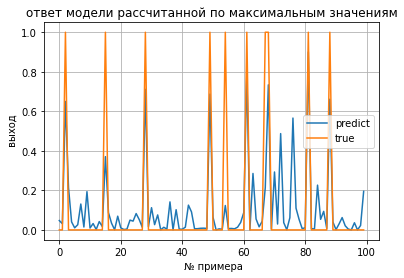

In [94]:
plt.plot( preds_max[:100], label = 'predict')
plt.plot(y_test_max.values[:100], label = 'true')
plt.title('ответ модели рассчитанной по максимальным значениям')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

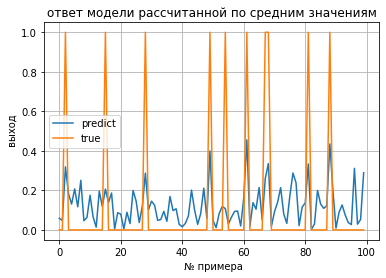

In [93]:
plt.plot( preds_mean[:100], label = 'predict')
plt.plot(y_test_mean.values[:100], label = 'true')
plt.title('ответ модели рассчитанной по средним значениям')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

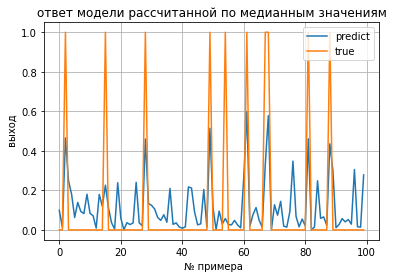

In [95]:
plt.plot( preds_median[:100], label = 'predict')
plt.plot(y_test_median.values[:100], label = 'true')
plt.title('ответ модели рассчитанной по медианным значениям')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

### Получение метрик и их сравнение

Precision, Recall, F1

In [99]:
precision_max, recall_max, thresholds_max = precision_recall_curve(y_test_max.values, preds_max)

In [100]:
precision_mean, recall_mean, thresholds_mean = precision_recall_curve(y_test_mean.values, preds_mean)

In [101]:
precision_median, recall_median, thresholds_median = precision_recall_curve(y_test_median.values, preds_median)

In [119]:
n=-1
fscore_max = (2 * precision_max[:n] * recall_max[:n]) / (precision_max[:n] + recall_max[:n])

In [120]:
# locate the index of the largest f score
ix = np.argmax(fscore_max)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_max[ix], 
                                                                        fscore_max[ix],
                                                                        precision_max[ix],
                                                                        recall_max[ix]))

Best Threshold=0.361369, F-Score=0.752, Precision=0.749, Recall=0.755


In [121]:
max_val = np.array([thresholds_max[ix], 
                      fscore_max[ix],
                      precision_max[ix],
                      recall_max[ix]])

In [122]:
fscore_mean = (2 * precision_mean[:n] * recall_mean[:n]) / (precision_mean[:n] + recall_mean[:n])

In [123]:
ix = np.argmax(fscore_mean)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_mean[ix], 
                                                                        fscore_mean[ix],
                                                                        precision_mean[ix],
                                                                        recall_mean[ix]))

Best Threshold=0.214422, F-Score=0.615, Precision=0.514, Recall=0.767


In [124]:
mean_val = np.array([thresholds_mean[ix], 
                      fscore_mean[ix],
                      precision_mean[ix],
                      recall_mean[ix]])

In [125]:
fscore_median = (2 * precision_median[:n] * recall_median[:n]) / (precision_median[:n] + recall_median[:n])

In [126]:
ix = np.argmax(fscore_median)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_median[ix], 
                                                                        fscore_median[ix],
                                                                        precision_median[ix],
                                                                        recall_median[ix]))

Best Threshold=0.292009, F-Score=0.720, Precision=0.721, Recall=0.718


In [127]:
median_val = np.array([thresholds_median[ix], 
                      fscore_median[ix],
                      precision_median[ix],
                      recall_median[ix]])

Графики Точность/Полнота

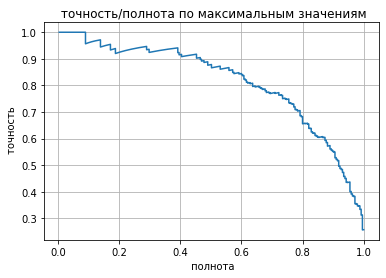

In [143]:
plt.plot(recall_max[:n],precision_max[:n] )
plt.title(' точность/полнота по максимальным значениям')
plt.xlabel(' полнота')
plt.ylabel(' точность')
plt.grid('On')
plt.show()

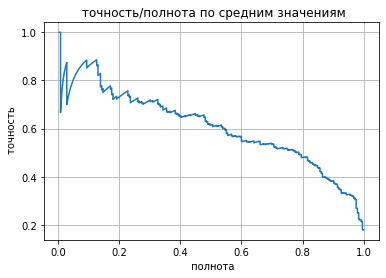

In [144]:
plt.plot(recall_mean[:n],precision_mean[:n] )
plt.title(' точность/полнота по средним значениям')
plt.xlabel(' полнота')
plt.ylabel(' точность')
plt.grid('On')
plt.show()

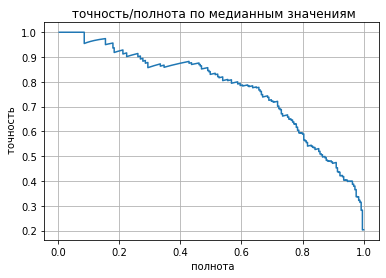

In [145]:
plt.plot(recall_median[:n],precision_median[:n] )
plt.title(' точность/полнота по медианным значениям')
plt.xlabel(' полнота')
plt.ylabel(' точность')
plt.grid('On')
plt.show()

ROC AUC
------------------------

In [140]:
roc_auc_score(y_test_max, preds_max)

0.9644049072620502

In [141]:
roc_auc_score(y_test_mean, preds_mean)

0.922104773533345

In [142]:
roc_auc_score(y_test_median, preds_median)

0.9542833885691029

In [149]:
n_classes = 2

In [183]:
fpr_max = dict()
tpr_max = dict()
roc_auc_max = dict()
fpr_max, tpr_max, _ = roc_curve(y_test_max, preds_max)
roc_auc_max = auc(fpr_max, tpr_max)

In [184]:
roc_auc_max

0.9644049072620502

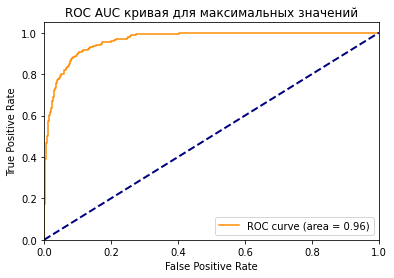

In [185]:
plt.figure()
lw = 2
plt.plot(
    fpr_max,
    tpr_max,
    color="darkorange",
    #lw=lw #,
    label="ROC curve (area = %0.2f)" % roc_auc_max,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC кривая для максимальных значений")
plt.legend(loc="lower right")
plt.show()

In [186]:
fpr_mean = dict()
tpr_mean = dict()
roc_auc_mean = dict()
fpr_mean, tpr_mean, _ = roc_curve(y_test_mean, preds_mean)
roc_auc_mean = auc(fpr_mean, tpr_mean)

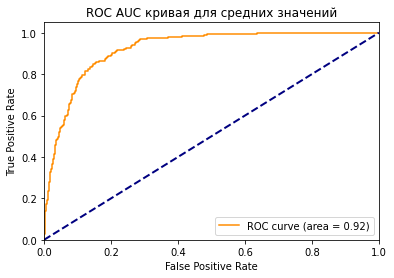

In [187]:
plt.figure()
lw = 2
plt.plot(
    fpr_mean,
    tpr_mean,
    color="darkorange",
    #lw=lw #,
    label="ROC curve (area = %0.2f)" % roc_auc_mean,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC кривая для средних значений")
plt.legend(loc="lower right")
plt.show()

In [188]:
fpr_median = dict()
tpr_median = dict()
roc_auc_median = dict()
fpr_median, tpr_median, _ = roc_curve(y_test_median, preds_median)
roc_auc_median = auc(fpr_median, tpr_median)

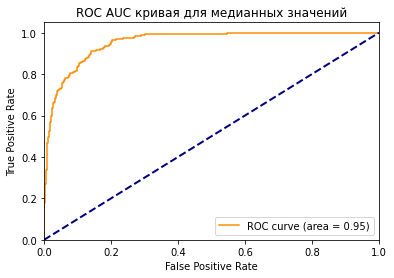

In [190]:
plt.figure()
lw = 2
plt.plot(
    fpr_median,
    tpr_median,
    color="darkorange",
    #lw=lw #,
    label="ROC curve (area = %0.2f)" % roc_auc_median,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC кривая для медианных значений")
plt.legend(loc="lower right")
plt.show()

при сравнении посчитанных величин можно сделать вывод, что работа с максимальными значениями обеспечивает самые высокие показатели качества в данном случае.

### Задание 5

5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

В качестве единой таблицы удобно использовать датафрэйм.

In [133]:
eval_array = np.vstack((max_val, mean_val, median_val))

In [134]:
eval_array

array([[0.36136864, 0.75203252, 0.74898785, 0.75510204],
       [0.21442207, 0.61538462, 0.5136612 , 0.76734694],
       [0.29200858, 0.7198364 , 0.72131148, 0.71836735]])

In [135]:
eval_df = pd.DataFrame(eval_array, 
                       columns = ['threshold', 'fscore', 'precision', 'recall'], 
                       index=['max', 'mean', 'medium'])

In [136]:
eval_df

,threshold,fscore,precision,recall
max,0.361369,0.752033,0.748988,0.755102
mean,0.214422,0.615385,0.513661,0.767347
medium,0.292009,0.719836,0.721311,0.718367


In [192]:
eval_df['ROC_AUC'] = [roc_auc_max, roc_auc_mean, roc_auc_median]

In [193]:
eval_df = eval_df.drop('threshold', axis = 1)

Окончательный вид таблицы с результаттами.

In [194]:
eval_df

,fscore,precision,recall,ROC_AUC
max,0.752033,0.748988,0.755102,0.964405
mean,0.615385,0.513661,0.767347,0.922105
medium,0.719836,0.721311,0.718367,0.954283


### Задание 6

6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Первичный анализ датасета, на котором обучалась модель при помощи гистограм.

array([[<AxesSubplot:title={'center':'topic_0'}>,
        <AxesSubplot:title={'center':'topic_1'}>,
        <AxesSubplot:title={'center':'topic_2'}>,
        <AxesSubplot:title={'center':'topic_3'}>,
        <AxesSubplot:title={'center':'topic_4'}>],
       [<AxesSubplot:title={'center':'topic_5'}>,
        <AxesSubplot:title={'center':'topic_6'}>,
        <AxesSubplot:title={'center':'topic_7'}>,
        <AxesSubplot:title={'center':'topic_8'}>,
        <AxesSubplot:title={'center':'topic_9'}>],
       [<AxesSubplot:title={'center':'topic_10'}>,
        <AxesSubplot:title={'center':'topic_11'}>,
        <AxesSubplot:title={'center':'topic_12'}>,
        <AxesSubplot:title={'center':'topic_13'}>,
        <AxesSubplot:title={'center':'topic_14'}>],
       [<AxesSubplot:title={'center':'topic_15'}>,
        <AxesSubplot:title={'center':'topic_16'}>,
        <AxesSubplot:title={'center':'topic_17'}>,
        <AxesSubplot:title={'center':'topic_18'}>,
        <AxesSubplot:title={'center':'

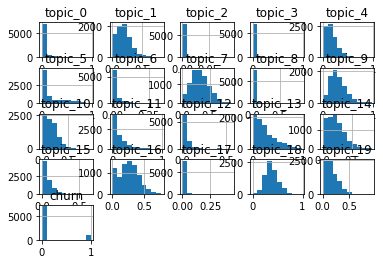

In [195]:
X_max.hist()

По результатам анализа таблицы составленной в предыдущем задании, можно сделать вывод, что результаты расчета по медианным значениям достаточно близки к результатам расчета по максимальным значениям.
Результаты по средним значениям имеют самые худшие показатели.  
Распределение значений признаков в датасете не относится к нормальному распределениию. величины явно смещены. А средние значения очень чувствительны к выбросам. Мелианнные значения, как правило, более устойчивы к ним.

Определенное влияние наверняяка оказал несбаланированность датасета по количеству значений целевой переменной.  
Для увеличения качества прогноза, возможно, следует попытаться сбалансировать датасет искусственными методами.

## Задание 4 - not completed.

4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.


Импортируем TfidfVectorizer и инициализируем его.

In [200]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [237]:
#vectorizer = TfidfVectorizer(stop_words=stopword_ru)
vectorizer = TfidfVectorizer()

Подготовка датасета для обработки.

In [214]:
users.shape

(8000, 2)

In [215]:
users.head()

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [217]:
user_articles = users['articles']

In [219]:
user_articles.head()

0    [293672, 293328, 293001, 293622, 293126, 1852]
1            [3405, 1739, 2972, 1158, 1599, 322665]
2            [1845, 2009, 2356, 1424, 2939, 323389]
3            [5933, 6186, 5055, 6977, 5206, 488389]
4             [707, 1144, 2532, 2928, 3133, 324592]
Name: articles, dtype: object

Превращение датасета в массив из значений статей, разделенных запятыми.  
Возможна подача в векторайзер массива значений без предобработки с использованием списка стоп слов и т.п. Но в этом случае результат оказщывается плохо идентифицируемым.

In [240]:
def row_to_str (param):
    return ''.join(map(str, param.split(',')))[1:-1]

In [231]:
user_articles_llist = user_articles.apply(row_to_str)

In [234]:
user_articles_llist = user_articles_llist.values

Конечный результат после преобразования.

In [235]:
user_articles_llist[:10]

array(['293672 293328 293001 293622 293126 1852',
       '3405 1739 2972 1158 1599 322665',
       '1845 2009 2356 1424 2939 323389',
       '5933 6186 5055 6977 5206 488389',
       '707 1144 2532 2928 3133 324592',
       '323868 323426 324267 322426 324104 1550',
       '293138 294471 295012 294736 293949 3544',
       '6928 5009 6940 7629 7644 512736',
       '322838 324699 322991 322120 324327 472331',
       '7827 6427 7394 7151 6335 487254'], dtype=object)

Обучение модели

In [245]:
X_tf = vectorizer.fit(user_articles_llist)

In [246]:
X_tf.transform(user_articles_llist)

<8000x14781 sparse matrix of type '<class 'numpy.float64'>'
	with 47957 stored elements in Compressed Sparse Row format>

In [247]:
X_tf.idf_

array([8.88870952, 7.90788027, 8.04141166, ..., 8.60102745, 9.29417463,
       8.60102745])

In [258]:
indeces = X_tf.get_feature_names()

In [259]:
weights = pd.DataFrame(X_tf.idf_, columns=['weights'], index=indeces)

In [260]:
weights.head()

,weights
10,8.888710
100,7.907880
1000,8.041412
1001,8.888710
1002,8.888710


In [ ]:
def get_user_embedding_tfidf(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])

    user_vector1 = np.max(user_vector, 0)  # можно не средний
    
    return user_vector1 